before stp
before jvkeywords
before stemming
['0', '1', '1', '1', '0', '1', '1', '1', '1', '0', '0', '1', '1', '0', '1', '0', '1', '1', '0', '1', '1', '1', '1', '0', '0', '0', '0', '0', '0', '0', '1', '1', '1', '1', '1', '1', '1', '0', '1', '1', '0', '1', '1', '1', '1', '0', '0', '1', '0', '1', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '1', '1', '0', '1', '0', '0', '0', '0', '1', '1', '0', '1', '1', '1', '1', '1', '1', '0', '1', '0', '0', '1', '1', '1', '0', '0', '1', '1', '0', '1', '0', '0', '1', '0', '1', '1', '1', '0', '0', '1', '0', '1', '0', '1', '0', '0', '0', '0', '1', '1', '1', '0', '1', '0', '1', '1', '0', '1', '1', '0', '1', '0', '0', '1', '0', '0', '0', '1', '1', '1', '1', '0', '0', '0', '0', '1', '1', '0', '1', '0', '1', '1', '0', '1', '0', '0', '1', '1', '1', '1', '1', '1', '0', '1', '0', '0', '1', '1', '1', '0', '1', '0', '0', '0', '0', '1', '0', '1', '0', '0', '1', '0', '1', '1', '0', '0', '1', '0', '1', '1', '0', '1', '1', '0', '0', '1', '1', '1', '0',

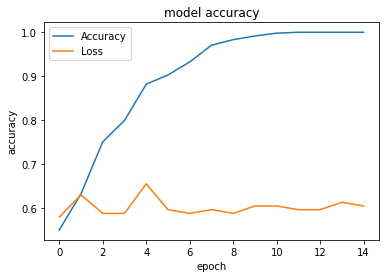

In [1]:
from sklearn import model_selection, preprocessing
import matplotlib.pyplot as plt
from keras.layers import Embedding, Lambda, SimpleRNN, Dropout, Dense, Concatenate, Conv1D, Bidirectional, LSTM, \
    GlobalAveragePooling1D, GlobalMaxPooling1D, BatchNormalization, Activation, Input, Embedding, MaxPooling1D, Flatten
from keras.callbacks import EarlyStopping
import numpy as np
from keras.models import Sequential, load_model
from keras.preprocessing import text, sequence
from keras.layers.merge import concatenate
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
import pandas as pd
from keras import layers, models, optimizers, Model
from lime.lime_text import LimeTextExplainer
import pickle
from BugReportPreprocessing import startpreprocess 
import Dataset


Data=[]
data = Dataset.getContent()
sdf=[]
X=[]
Y=[]
Summary=[]
Description=[]
Files=[]

for i in data:
     Y.append(i['output'])
print(Y)
print(len(Y))

Data = startpreprocess(data)
for i in Data:
    for j in i['description'].values():
        Description.append(" ".join(j))
        break
for i in Data:
    for j in i['summary'].values():
        Summary.append(" ".join(j))
        break
for i in Data:
    for j in i['files'].values():
        Files.append(" ".join(j))
        break

sdf = np.stack((Summary, Description, Files), axis=1)    

for i in sdf:
    X.append(" ".join(i))


    
print(len(X))

print(X[5])    
#print(Y[8])


testRatio = int(0.15 * len(data))
print(testRatio)
testData = data[0:testRatio]
data = data[testRatio:300000]


# set parameters:
batch_size = 32
embedding_dims = 100
epochs = 10
maxlen = 65

train_x, test_x, train_y, test_y = model_selection.train_test_split(X, Y, test_size=0.2, random_state=42)

encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
test_y = encoder.fit_transform(test_y)

tokenizer = text.Tokenizer(oov_token=True)

tokenizer.fit_on_texts(train_x)

vocab_size = len(tokenizer.word_index) + 1

train_x = tokenizer.texts_to_sequences(train_x)
test_x = tokenizer.texts_to_sequences(test_x)

train_x = sequence.pad_sequences(train_x, maxlen=maxlen, padding='post')
test_x = sequence.pad_sequences(test_x, maxlen=maxlen, padding='post')


def createEmbeddingsMatrix(tokenizer):
    # Create an embedding dictionary by splitting the word from its vector representation
    embeddings_index = dict()
    # Loops over all the words in the glove file and extracts each word seperated from its vector
    f = open('glove.6B.100d.txt', encoding="utf8")
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()

    # Create an empty embedding matrix with size of number of words x vector dimension
    embedding_matrix = np.zeros((vocab_size, embedding_dims))
    # Map each word in tokenizer dictionary to vectors in the embedding dictionary
    for word, index in tokenizer.word_index.items():
        if index > vocab_size - 1:
            break
        else:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[index] = embedding_vector
    return embedding_matrix

embeddings = createEmbeddingsMatrix(tokenizer)

def singleCNN(vocab_size, max_length):
    model = Sequential()
    model.add(
        layers.Embedding(vocab_size, embedding_dims, input_length=max_length, weights=[embeddings], trainable=False))
    # model.add(layers.SpatialDropout1D(0.25))
    model.add(layers.Conv1D(filters=50, kernel_size=2, activation='relu'))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Flatten())
    model.add(layers.Dense(16, activation='relu'))
    # model.add(layers.SpatialDropout1D(0.25))
    model.add(layers.Dense(1, activation='sigmoid'))
    # compile the network
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # model diagram
    model.summary()

    return model

model = singleCNN(vocab_size, maxlen)
history =model.fit(train_x,train_y,batch_size=batch_size,
                       epochs=epochs,verbose=1,
                       shuffle=True,
                       validation_data=(test_x, test_y))
print(vocab_size)
print(maxlen)



plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Accuracy', 'Loss'], loc='upper left')
plt.show()